## Step 1: Try login in to LinkedIn

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time

# Set up Selenium WebDriver
options = webdriver.ChromeOptions()
options.add_argument("--start-maximized")  # Open browser in full screen
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

try:
    # Navigate to LinkedIn login page
    driver.get("https://www.linkedin.com/login")
    time.sleep(3)  # Wait for page to load

    # Enter credentials (replace with your own; store securely in practice)
    username = "-"  # Replace with your email
    password = "-"  # Replace with your password
    driver.find_element(By.ID, "username").send_keys(username)
    driver.find_element(By.ID, "password").send_keys(password)

    # Submit login form
    driver.find_element(By.XPATH, "//button[@type='submit']").click()
    time.sleep(5)  # Wait for login to complete (adjust if 2FA is enabled)

    # Verify login by checking for profile link (basic check)
    if "feed" in driver.current_url:
        print("Login successful!")
    else:
        print("Login may have failed. Check for 2FA or errors.")

except Exception as e:
    print(f"Error during login: {e}")

finally:
    # Keep browser open for next steps (will close in final step)
    pass

Login successful!


In [29]:
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import time
import networkx as nx

try:
    # Navigate to connections page
    driver.get("https://www.linkedin.com/mynetwork/invite-connect/connections/")
    time.sleep(5)  # Wait for page to load

    # Scroll to load more connections
    for _ in range(3):  # Scroll 3 times; adjust as needed
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)  # Wait for content to load

    # Parse page source with Beautiful Soup
    soup = BeautifulSoup(driver.page_source, "html.parser")

    # Initialize NetworkX directed graph
    G = nx.DiGraph()
    main_user = "https://www.linkedin.com/in/ngai-fung-ng-302260258/"  # Replace with your LinkedIn username or placeholder

    # Find <p> tags with the specified class, then get <a> tags inside
    parent_elements = soup.find_all("p", class_="_1s9oaxgp")
    connection_names = []
    connection_sites = []

    for parent in parent_elements:
        # Look for <a> tags with classes _139m7k1io and _3g29zz0 inside this <p>
        conn = parent.find("a", class_=["_139m7k1io", "_3g29zz0"])
        if conn:
            site = conn.get("href")  # Get the href attribute
            if site and site != main_user and site not in connection_sites:  # Avoid duplicates and self
                # connection_names.append(name)
                connection_sites.append(site)
                G.add_edge(main_user, site)  # Add 1st-degree edge
                print(f"Added 1st-degree edge: {main_user} -> {site}")
            else:
                print(f"Skipped duplicate or self: {site}")

    # Output results
    print(f"\nFound {len(connection_sites)} connections.")
    print("Sample connections:", connection_sites[:5])  # Show first 5
    print("Graph nodes:", G.number_of_nodes())
    print("Graph edges:", G.number_of_edges())

except Exception as e:
    print(f"Error during Step 2: {e}")

finally:
    # Keep browser open for Step 3
    pass
    # Uncomment to close: driver.quit()

Added 1st-degree edge: https://www.linkedin.com/in/ngai-fung-ng-302260258/ -> https://www.linkedin.com/in/sh-tsang/
Added 1st-degree edge: https://www.linkedin.com/in/ngai-fung-ng-302260258/ -> https://www.linkedin.com/in/charleswongsk/
Added 1st-degree edge: https://www.linkedin.com/in/ngai-fung-ng-302260258/ -> https://www.linkedin.com/in/ng-teng-fong-sino-group-belt-and-road-research-institute-73b4982b0/
Added 1st-degree edge: https://www.linkedin.com/in/ngai-fung-ng-302260258/ -> https://www.linkedin.com/in/ivancyw/
Added 1st-degree edge: https://www.linkedin.com/in/ngai-fung-ng-302260258/ -> https://www.linkedin.com/in/yuk-sum-tam-0b7360254/
Added 1st-degree edge: https://www.linkedin.com/in/ngai-fung-ng-302260258/ -> https://www.linkedin.com/in/andy-ng-585542258/
Added 1st-degree edge: https://www.linkedin.com/in/ngai-fung-ng-302260258/ -> https://www.linkedin.com/in/kametayturar/

Found 7 connections.
Sample connections: ['https://www.linkedin.com/in/sh-tsang/', 'https://www.lin

In [31]:
def scrape_connections(driver, input_sites, G, main_user, degree, max_profiles=3, max_pages=3):
    """
    Scrape connections for a given degree, up to max_pages per profile.
    Returns new URLs for the next degree.
    """
    print(f"\nScraping {degree}th-degree connections...")
    new_sites = []

    # Regex to clean URLs
    url_pattern = re.compile(r"(https://www\.linkedin\.com/in/[^?]+)")

    # Limit to max_profiles
    for site in input_sites[:max_profiles]:
        try:
            # Ensure full URL
            if not site.startswith("https"):
                site = "https://www.linkedin.com" + site

            # Visit profile
            driver.get(site)
            time.sleep(3)

            # Find connections page link
            soup = BeautifulSoup(driver.page_source, "html.parser")
            ul_element = soup.find("ul", class_=["HOvVSqNZaRvoMvjPmkGofuXspzSMzXczo", "gQOGMGqxxtDJcDAmvskVngtoYGWZgTyolbA"])
            connections_url = None
            if ul_element:
                conn_link = ul_element.find("a", href=lambda x: x and "search/results/people/?connectionOf" in x)
                if conn_link and "href" in conn_link.attrs:
                    connections_url = conn_link["href"]
                    if not connections_url.startswith("https"):
                        connections_url = "https://www.linkedin.com" + connections_url

            if connections_url:
                # Visit connections page (starts at page 1)
                driver.get(connections_url)
                time.sleep(5)

                # Scrape up to max_pages
                for page in range(1, max_pages + 1):
                    try:
                        # Scroll to load current page
                        for _ in range(2):
                            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                            time.sleep(2)

                        # Parse connections
                        soup = BeautifulSoup(driver.page_source, "html.parser")
                        parent_elements = soup.find_all("span", class_="RymbcHKoixNzHHazKgojebkDZPdCDlemnZHiM")

                        for parent in parent_elements:
                            friend_conn = parent.find("a", attrs={"data-test-app-aware-link": ""})
                            if friend_conn and "href" in friend_conn.attrs:
                                friend_site = friend_conn["href"]
                                # Clean URL
                                match = url_pattern.match(friend_site)
                                if match:
                                    friend_site = match.group(1)
                                    if (friend_site and friend_site != site and 
                                        friend_site != main_user and friend_site not in input_sites):
                                        G.add_edge(site, friend_site)
                                        print(f"Added {degree}th-degree edge: {site} -> {friend_site}")
                                        if friend_site not in new_sites:
                                            new_sites.append(friend_site)

                        # Move to next page (if not the last)
                        if page < max_pages:
                            soup = BeautifulSoup(driver.page_source, "html.parser")
                            pagination = soup.find("ul", class_="artdeco-pagination__pages")
                            if pagination:
                                next_page_btn = pagination.find("li", attrs={"data-test-pagination-page-btn": str(page + 1)})
                                if next_page_btn:
                                    button = driver.find_element(By.XPATH, f"//button[@aria-label='Page {page + 1}']")
                                    driver.execute_script("arguments[0].click();", button)
                                    time.sleep(5)  # Wait for page load
                                else:
                                    print(f"No page {page + 1} found for {site}. Stopping at page {page}.")
                                    break
                            else:
                                print(f"No pagination found for {site}. Stopping at page {page}.")
                                break

                    except Exception as e:
                        print(f"Error on page {page} for {site}: {e}")
                        break

            else:
                print(f"No connections page link found for {site}. Skipping...")

        except Exception as e:
            print(f"Error scraping connections for {site}: {e}")
            continue

        # Delay to avoid rate limits
        time.sleep(5)

    print(f"Found {len(new_sites)} {degree}th-degree connections.")
    return new_sites

try:
    # Scrape 2nd-degree connections (3 pages each)
    second_degree_sites = scrape_connections(driver, connection_sites, G, main_user, degree=2, max_profiles=3, max_pages=3)

    # Scrape 3rd-degree connections (3 pages each)
    third_degree_sites = scrape_connections(driver, second_degree_sites, G, main_user, degree=3, max_profiles=3, max_pages=3)

    # Extend to 4th-degree (optional, uncomment cautiously)
    

    # Output final results
    print(f"\nAll scraping complete.")
    print("Total graph nodes:", G.number_of_nodes())
    print("Total graph edges:", G.number_of_edges())

except Exception as e:
    print(f"Error during Step 3+: {e}")

finally:
    # Keep browser open
    pass
    # Uncomment to close: driver.quit()


Scraping 2th-degree connections...
Added 2th-degree edge: https://www.linkedin.com/in/sh-tsang/ -> https://www.linkedin.com/in/kathy-leung-4a640a79
Added 2th-degree edge: https://www.linkedin.com/in/sh-tsang/ -> https://www.linkedin.com/in/kwok-tung-lo-b557b888
Added 2th-degree edge: https://www.linkedin.com/in/sh-tsang/ -> https://www.linkedin.com/in/richard-tai-chiu-hsung-2266b247
Added 2th-degree edge: https://www.linkedin.com/in/sh-tsang/ -> https://www.linkedin.com/in/ivan-ho-754173b
Added 2th-degree edge: https://www.linkedin.com/in/sh-tsang/ -> https://www.linkedin.com/in/tierui-gong-22231ab6
Added 2th-degree edge: https://www.linkedin.com/in/sh-tsang/ -> https://www.linkedin.com/in/dr-kopperundevi-p-6033bbba
Added 2th-degree edge: https://www.linkedin.com/in/sh-tsang/ -> https://www.linkedin.com/in/ginny-wong-phd-3985bab5
Added 2th-degree edge: https://www.linkedin.com/in/sh-tsang/ -> https://www.linkedin.com/in/k-w-wong-39046646
Added 2th-degree edge: https://www.linkedin.com


Starting Step 4: Plotting the graph...


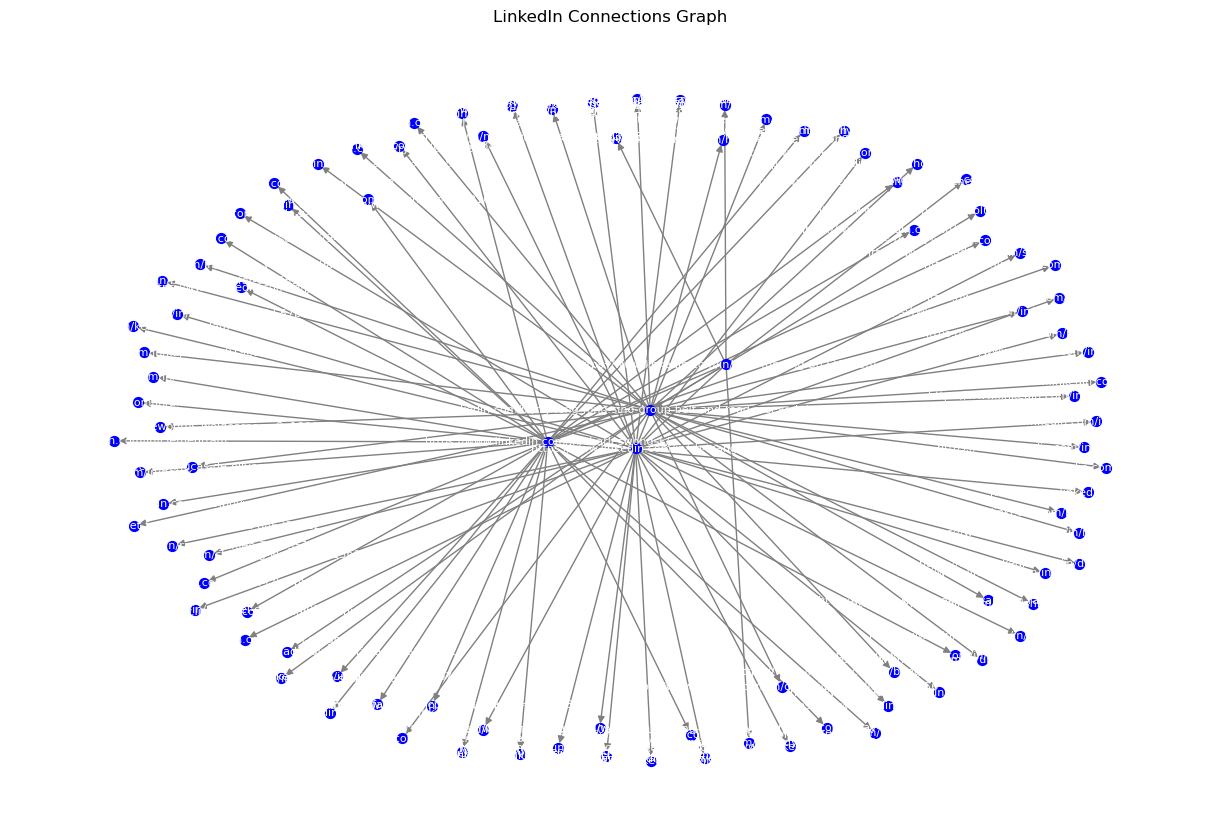

Graph plotted successfully.


In [33]:
# plot the graph
import matplotlib.pyplot as plt
import networkx as nx


try:
    # Step 4: Plot the graph
    print("\nStarting Step 4: Plotting the graph...")

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw(G, pos, with_labels=True, node_size=50, node_color="blue", font_size=8, font_color="white", edge_color="gray")
    plt.title("LinkedIn Connections Graph")
    plt.show()
    print("Graph plotted successfully.")


except Exception as e:
    print(f"Error during Step 4: {e}")


finally:
    # Close the browser
    # driver.quit()
    # print("Browser closed.")
    pass